In [ ]:
%load_ext autoreload

%autoreload 2

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline
xref = np.array([1e-9, 1e-9, 1e-9])

In [57]:
def z_function(x,y):
    return x**2 + y**2

def get_jacobian(net, x, noutputs):
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data

class FeedForwardNet(nn.Module):
    def __init__(self, input_features, output_features):
        super(FeedForwardNet, self).__init__()
        

        self.fc1 = nn.Linear(input_features, 16)
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.normal_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias, -f1, f1)        
        

        self.fc2 = nn.Linear(16, 16)
        f2 = 1 / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.normal_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias, -f2, f2)        
        
                
        self.fc3 = nn.Linear(16, 1)
        f3 = 1 / np.sqrt(self.fc3.weight.data.size()[0])
        torch.nn.init.normal_(self.fc3.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.fc3.bias, -f3, f3)    
      
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        
        x1 = torch.tanh(self.fc1(x)) 
        x2 = torch.relu(self.fc2(x1)) 
        x3 = self.fc3(x2) 
        
        return x3

In [58]:
def a2m(a):
    return np.matrix(a).T

def generateNumpyData(size = 1000, test=False):

    
    xtrain = []
    ytrain = []
    for _ in range(size):
        if not test:
            xyz = np.array([np.random.uniform(-2.1, 2.1), 
                       np.random.uniform(-2.1, 2.1),
                       np.random.uniform(0, 1)])
    
        if test:
            x = np.linspace(-2.1 , 2.1, 1000)
            Y = np.linspace(-2.1 , 2.1, 1000)
            z = np.linspace(0, 1, 1000)
            
            xyz = np.array([i, j, k])


        ytrain.append(np.array([sum(a2m(xyz))**2]))
        
    
    return np.asarray(xtrain), np.asarray(ytrain)

In [59]:
def trainFfn(net, start, cost, epochs = 10):
    from tqdm import tqdm
    net = net.float()
    net.train()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    n_epochs = epochs
    for epoch in tqdm(range(n_epochs)):
        for x, y in zip(start, cost):
                       
            optimizer.zero_grad()
            y_ = net(x)          
            loss = torch.sum((torch.abs(y_ - y))**2)

            loss.backward()
            optimizer.step()  
    del start, cost        
    return net
    

In [60]:
xtrain, ytrain = generateNumpyData()
xtrain = torch.as_tensor(xtrain, dtype = torch.float32)
ytrain = torch.as_tensor(ytrain, dtype = torch.float32)
net = FeedForwardNet(xtrain.shape[1], ytrain.shape[1])
ffn = trainFfn(net, xtrain, ytrain)

IndexError: tuple index out of range

In [ ]:
# Calculate MSE for test
def evalMSE(net, size  = 10000):
    x, lx = generateNumpyData(size)
    net.eval()
    totalLoss = 0.
    with torch.no_grad():
        for test, target in zip(x, lx):
            test = torch.as_tensor(test, dtype = torch.float32)
            prediction = net(test).cpu().detach().numpy()
            totalLoss += np.abs(prediction - target) ** 2
    return totalLoss / size
        
        

In [ ]:
print(f"MSE for feedforward Network is : {evalMSE(ffn, 1000)}")

In [ ]:
# Calculate MSDE

def evalMSDE(net, size=1000):
    def numpyMSE(x):
        """
        this should return the ytrain
        """
        return np.sum(np.abs(x - xref )**2)
    
    jacobianLossFunction = nd.Jacobian(numpyMSE)
    net.eval()
    MSDE = 0.
    for _ in range(size):
        xyz = np.array([np.random.uniform(-2.1, 2.1), 
                       np.random.uniform(-2.1, 2.1),
                       np.random.uniform(0, 1)])
        
        # calculate the derivative of loss with respect to numpy, del L
        delLf = jacobianLossFunction(xyz)
        
        # convert input to tensor
        test = torch.as_tensor(xyz, dtype = torch.float32)
        # Get derivative of net prediction
        delNw = get_jacobian(net, test, 1).detach().numpy()
        
        # Calculate the sum of squared errors for the two arrays
        loss = np.sum(np.abs(delLf - delNw )**2)
        MSDE += loss
        
    return MSDE / size


In [ ]:
print(f"MSDE for feedforward Network is : {evalMSDE(ffn, 1000)}")                  


In [ ]:
def mse_plot_data(net, size=1000):
    xyz, lx = generateNumpyData(size, True)
    net.eval()
    mse = []
    for test, target in zip(xyz, lx):
        test = torch.as_tensor(test, dtype = torch.float32)
        prediction = net(test).cpu().detach().numpy()
        mse.append(np.array([np.abs(prediction - target) ** 2]))
    mse = np.array(mse).squeeze().reshape(size, 1)
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = mse[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.figure(figsize=(6,5))
    #plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
    plt.pcolormesh(z_resampled)
    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()
    clb.set_label("||L - N(w)|| **2", labelpad=-30, y=1.10, rotation=0)
    plt.title("FeedForward Net")
    #plt.savefig("FFn LNW.png")
    plt.show()
    plt.close()

mse_plot_data(ffn)    

In [ ]:
def msde_plot_data(net, size=2000):
    def numpyMSE(x):
        """
        this should return the ytrain
        """
        return np.sum(np.abs(x - xref )**2)
    positions = []
    jacobianLossFunction = nd.Jacobian(numpyMSE)
    net.eval()
    msde = []
    for _ in range(size):
        xyz = np.array([np.random.uniform(-0.2, 0.2), 
                       np.random.uniform(-0.2, 0.2),
                       np.random.uniform(0, 1)])
        positions.append(xyz)
        # calculate the derivative of loss with respect to numpy, del L
        delLf = jacobianLossFunction(xyz)
        
        # convert input to tensor
        test = torch.as_tensor(xyz, dtype = torch.float32)
        # Get derivative of net prediction
        delNw = get_jacobian(net, test, 1).detach().numpy()
        
        # Calculate the sum of squared errors for the two arrays
        loss = np.sum((a2m(delLf) - a2m(delNw ))**2)
        msde.append(np.array([loss]))
        
    msde = np.array(msde).squeeze().reshape(size, 1)
    positions = np.array(positions)
    
    x = positions[:,0]
    y = positions[:,1]
    z = msde[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) 
    plt.figure(figsize=(6,5))

    plt.imshow(z_resampled,
               interpolation="none",
               extent=extent,
               origin="lower",
               aspect='auto',
               )

    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()
    clb.set_label("||del L - del N(w)||**2", labelpad=-30, y=1.10, rotation=0)

    plt.title("FeedForward Net")
    #plt.savefig("FFn delLNW.png")
    plt.show()
    
msde_plot_data(ffn)

In [ ]:

#torch.save(ffn, 'ffn.pth')

In [ ]:
from matplotlib import cm

def scatter1():
    xyz, lx = generateNumpyData(100000, True)
    lx = lx.squeeze().reshape(100000, 1)
    x = xyz[:,0]
    y = xyz[:,1]
    z = lx[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.ogrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    norm = cm.colors.Normalize(vmax=abs(z).max(), vmin=-abs(z).max())

    plt.figure(figsize=(6,5), dpi = 80)

    #plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
    #plt.xlim(-0.2, 0.2)
    #plt.ylim(-0.2,0.2)
    plt.scatter(x, y, c=z, norm = norm, marker = ",", alpha = 0.9, linewidths = 0.3, edgecolors=None)
    plt.xticks(np.arange(-.3, .31, step=.1))
    plt.yticks(np.arange(-.3, .31, step=.1))
    clb = plt.colorbar()
    clb.set_label("L(x))", labelpad=-30, y=1.10, rotation=0)
    plt.title("Loss Function")
    #plt.savefig("Loss3.png")
    plt.show()


In [ ]:
scatter1()

In [ ]:
xyz, lx = generateNumpyData(100000, True)

In [ ]:
lx = lx.squeeze().reshape(100000, 1)
x = xyz[:,0]
y = xyz[:,1]
z = lx[:,0]
#extent = (min(x), max(x), min(y), max(y))
#xs,ys = np.ogrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
#z_resampled = griddata((x, y), z, (xs, ys)) #2D z
#norm = cm.colors.Normalize(vmax=abs(z).max(), vmin=-abs(z).max())

plt.figure(figsize=(6,5), dpi = 80)

#plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
#plt.xlim(-0.2, 0.2)
#plt.ylim(-0.2,0.2)
plt.scatter(x, y, c=z)
plt.xticks(np.arange(-.3, .31, step=.1))
plt.yticks(np.arange(-.3, .31, step=.1))
clb = plt.colorbar()
clb.set_label("L(x))", labelpad=-30, y=1.10, rotation=0)
plt.title("Loss Function")
#plt.savefig("Loss3.png")
plt.show()

In [ ]:
def scatter2(net):
    xyz, lx = generateNumpyData(1000, True)
    net.eval()
    predictions = []
    for test, target in zip(xyz, lx):
        test = torch.as_tensor(test, dtype = torch.float32)
        prediction = net(test).cpu().detach().numpy()
        predictions.append(np.array([prediction]))
        
    predictions = np.array(predictions).squeeze().reshape(1000, 1)
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = predictions[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.figure(figsize=(6,5))

    plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
    #plt.xlim(-0.2, 0.2)
    #plt.ylim(-0.2,0.2)
    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()
    clb.set_label("N(x))", labelpad=-30, y=1.10, rotation=0)
    plt.title("FeedForward")
    #plt.savefig("nw1.png")
    plt.show()    

In [ ]:
scatter2(ffn)

In [ ]:
def a2m(a):
    return np.matrix(a).T

def generatePlotData(size = 1000):

    
    xtrain = []
    ytrain = []

    x = np.linspace(-2.1 , 2.1, size)
    y = np.linspace(-2.1 , 2.1, size)
    z = np.linspace(0, 1, size)
            
            
    for i, j, k in zip(x,y,z):
        xyz = np.array([i, j, k])
        cost = np.square(np.abs(xyz)).sum()
        ytrain.append(np.array([cost]))
        xtrain.append(xyz)
        
        
        

    xtrain = np.array(xtrain)
    ytrain = np.array(ytrain)
    print(xtrain.shape)
    print(ytrain.shape)
    
    return xtrain, ytrain


def scatter1(size):
    xyz, lx = generatePlotData(size, True)
    lx = lx.tolist()
    x = xyz[:,0].tolist()
    y = xyz[:,1].tolist()
    z = lx
    
    
    

    # define grid.
    xi = np.linspace(-2.1, 2.1, 100)
    yi = np.linspace(-2.1, 2.1, 200)
    # grid the data.
    zi = griddata(x, y, z, xi, yi, 'linear')
    # contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(xi, yi, zi, 15,
                      vmax=abs(zi).max(), vmin=-abs(zi).max())
    plt.colorbar()  # draw colorbar
    # plot data points.
    plt.scatter(x, y, marker='o', s=5, zorder=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title('griddata test (%d points)' % npts)
    plt.show()

    
    
    

In [ ]:
scatter1(1000)

In [ ]:
x = np.linspace(-2.1 , 2.1, 1)

In [ ]:
x

In [48]:
#https://stackoverflow.com/questions/38749140/how-to-make-a-matrix-out-of-existing-xyz-data

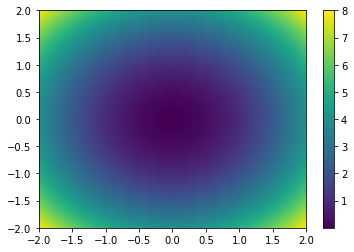

In [54]:
def method_1():
    min_x, max_x, dim_x = (-2, 2, 1000)
    min_y, max_y, dim_y = (-2, 2, 1000)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)

    X,Y = np.meshgrid(x,y)

    def z_function(x,y):
        return x**2 + y**2

    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.show()
    
method_1()

In [61]:
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)

In [64]:
z_function(x, y).shape

(1000,)

In [65]:
x

array([-2.        , -1.995996  , -1.99199199, -1.98798799, -1.98398398,
       -1.97997998, -1.97597598, -1.97197197, -1.96796797, -1.96396396,
       -1.95995996, -1.95595596, -1.95195195, -1.94794795, -1.94394394,
       -1.93993994, -1.93593594, -1.93193193, -1.92792793, -1.92392392,
       -1.91991992, -1.91591592, -1.91191191, -1.90790791, -1.9039039 ,
       -1.8998999 , -1.8958959 , -1.89189189, -1.88788789, -1.88388388,
       -1.87987988, -1.87587588, -1.87187187, -1.86786787, -1.86386386,
       -1.85985986, -1.85585586, -1.85185185, -1.84784785, -1.84384384,
       -1.83983984, -1.83583584, -1.83183183, -1.82782783, -1.82382382,
       -1.81981982, -1.81581582, -1.81181181, -1.80780781, -1.8038038 ,
       -1.7997998 , -1.7957958 , -1.79179179, -1.78778779, -1.78378378,
       -1.77977978, -1.77577578, -1.77177177, -1.76776777, -1.76376376,
       -1.75975976, -1.75575576, -1.75175175, -1.74774775, -1.74374374,
       -1.73973974, -1.73573574, -1.73173173, -1.72772773, -1.72